In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from patchify import patchify
from skimage import metrics
import argparse
import imutils
import glob
from PIL import Image
from itertools import product
import os
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from skimage.io import imread
from skimage.color import rgb2gray
import io
from urllib.request import urlopen
import IPython
import  PIL as pillow
from PIL import Image
from math import log10, sqrt
import matplotlib.mlab as mlab
import matplotlib.pylab as pylab
import scipy
import statistics
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy.fftpack import fft, dct
from scipy import signal
from scipy import misc


## metrics

In [3]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [4]:
image = cv2.imread(r'C:\Users\fateme\Desktop\face\test\4.png')

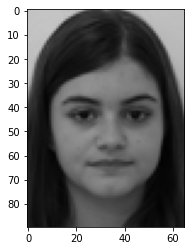

In [5]:
plt.imshow(image)

## add guassian noise to test image

In [6]:
def create_gaussian_noise(img,mean=0,var=0.01):
    
    # Converting pixel values from 0-255 to 0-1 float
    img = img/255

    # Initializing the result (noisy) image
    result = img.copy()

    # Adding gaussian noise to the image
    gauss = np.random.normal(mean, var**0.5, img.shape)
    result = result + gauss
    result = np.clip(result, 0, 1)

    # Converting the result back to uint8
    result = np.uint8(result*255)

    return result
noisy_image = create_gaussian_noise(image)
noisy_image.shape

(90, 65, 3)

PSNR: 28.448904733517605


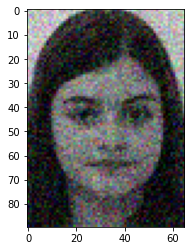

In [7]:
plt.imshow(noisy_image)

print('PSNR: {}'.format(PSNR(image,noisy_image)))

In [8]:
cv2.imwrite('noisy_image.png',noisy_image)

True

## find candidate images based on ssim

In [9]:
train_img = []
for img in glob.glob(r'C:\Users\fateme\Desktop\face\train\*.png'):
    n= cv2.imread(img)
    train_img.append(n)

In [10]:
similar_images = [] 
for smpl in train_img:
    
    # load the two input images
    imageA = noisy_image
    imageB = smpl

    # convert the images to grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

    # compute the Structural Similarity Index (SSIM) between the two
    # images, ensuring that the difference image is returned
    (score, diff) = metrics.structural_similarity(grayA, grayB, full=True)
    diff = (diff * 255).astype("uint8")
    print("SSIM: {}".format(score))
    if score > 0.28 :
        similar_images.append(imageB)

SSIM: 0.16759554018139014
SSIM: 0.28948021572004434
SSIM: 0.22165715058320093
SSIM: 0.17245041222031998
SSIM: 0.23000261413148088
SSIM: 0.17582770627364377
SSIM: 0.28936885831711967
SSIM: 0.19410295129397578
SSIM: 0.18810474644316555
SSIM: 0.1932062208011446
SSIM: 0.2699786484251889
SSIM: 0.22851030142584314
SSIM: 0.23603367105105413
SSIM: 0.19968816318768978
SSIM: 0.1424508875286146
SSIM: 0.12709644260982542
SSIM: 0.13913886175033593
SSIM: 0.242345983711796
SSIM: 0.1517092082446106
SSIM: 0.253429772053914
SSIM: 0.2461110207925704
SSIM: 0.13683832230627835
SSIM: 0.3150367691037218
SSIM: 0.15428525471366478
SSIM: 0.17839355495233947
SSIM: 0.16138087852927252
SSIM: 0.22619356748518626
SSIM: 0.14867875684438067
SSIM: 0.27367639557291396
SSIM: 0.17745889194381928
SSIM: 0.18608025808054757
SSIM: 0.2504724447126288
SSIM: 0.22093180042155736
SSIM: 0.15426554010979487
SSIM: 0.2368156814777636
SSIM: 0.16527032947541354
SSIM: 0.3689309859961691
SSIM: 0.23165862969028989
SSIM: 0.19759527830176563

In [11]:
#save similar img
for i in range(0,len(similar_images)):
    cv2.imwrite(r'C:\Users\fateme\Desktop\candidate\{}.png'.format(i),similar_images[i])

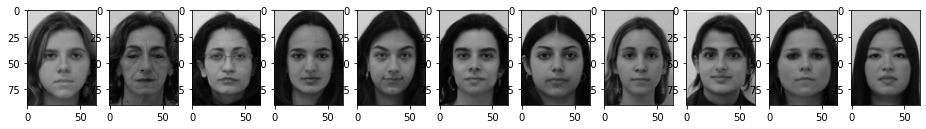

In [12]:
#show similar image
_, axs = plt.subplots(1,len(similar_images), figsize=(16, 12))
axs = axs.flatten()
for img, ax in zip(similar_images, axs):
    ax.imshow(img)
plt.show()


## divide noisy-image and candidate to patches

In [13]:
def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        img.crop(box).save(out)

In [14]:
tile('noisy_image.png',r'C:\Users\fateme\Desktop',r'C:\Users\fateme\Desktop\patch_nimg',30)

In [15]:
for img in glob.glob(r'C:\Users\fateme\Desktop\candidate\*.png'):
    n= cv2.imread(img)
    tile(img,r'C:\Users\fateme\Desktop',r'C:\Users\fateme\Desktop\candidate_patches',30)

# Euclidean distance between patches

In [16]:
def Average(lst):
    return sum(lst) / len(lst)

In [17]:
import scipy.spatial.distance as dist

def euclid_threshhold(path):
    disct =[]
    for img in glob.glob(r'C:\Users\fateme\Desktop\candidate_patches\*.png'):

        im1 = cv2.imread(path)
        im2 = cv2.imread(img)
        z = dist.euclidean(im1.flatten(), im2.flatten())
        print(z)
        disct.append(z)
    avg = Average(disct)
    print('the average is '+ str(avg))
    return avg

In [18]:
path_1 = r"C:\Users\fateme\Desktop\patch_nimg\noisy_image_0_0.png"
path_2 = r"C:\Users\fateme\Desktop\patch_nimg\noisy_image_0_30.png"
path_3 = r"C:\Users\fateme\Desktop\patch_nimg\noisy_image_30_0.png"
path_4 = r"C:\Users\fateme\Desktop\patch_nimg\noisy_image_30_30.png"
path_5 = r"C:\Users\fateme\Desktop\patch_nimg\noisy_image_60_0.png"
path_6 = r"C:\Users\fateme\Desktop\patch_nimg\noisy_image_60_30.png"

avg1 = euclid_threshhold(path_1)
avg2 = euclid_threshhold(path_2)
avg3 = euclid_threshhold(path_3)
avg4 = euclid_threshhold(path_4)
avg5 = euclid_threshhold(path_5)
avg6 = euclid_threshhold(path_6)

9735.814347038464
7914.09489455364
8382.942204262177
7996.26068859689
8654.129765609017
8149.626371803802
8805.473468246895
8134.437104065652
8800.42135354893
8237.423747750263
8856.73608052086
8413.424570292409
8826.19991842469
7739.748316321404
8591.857831691583
7827.977324954384
8080.1759881824355
7809.728612442304
8439.357499241278
7652.097947621946
8507.382441150745
7694.362676661401
8613.057587175415
7624.46686660779
8570.950997409798
7832.405313822824
8786.29569272512
7619.844420983935
8740.430710211025
7380.0613141084405
8091.087071586858
7677.072619169367
8370.994146455963
7672.939593141601
8562.904997721276
8234.67303540341
8453.316686366365
7784.800190114066
8412.674723296985
8012.1834102821185
8555.662861520434
8405.736969475074
8398.019468898605
7796.253138527507
8532.893706123381
7523.517594848835
8391.343634960971
8563.063996023853
8400.166486445372
7791.684541868979
8580.408731523225
7811.66461133605
8710.453949134913
8482.98414474529
the average is 8252.47567342585
750

In [30]:
def list_nearest(path , avg):
    lst =[]
    lst_img = []
    for img in glob.glob(r'C:\Users\fateme\Desktop\candidate_patches\*.png'):

        im1 = cv2.imread(path)
        im2 = cv2.imread(img)
        x = dist.euclidean(im1.flatten(), im2.flatten())
        if (x) <= avg:
            lst.append(x)
            lst_img.append(im2)
    return lst , lst_img

In [31]:
lst_1, lst_img_1 = list_nearest(path_1,avg1)
lst_2, lst_img_2 = list_nearest(path_2,avg2)
lst_3, lst_img_3 = list_nearest(path_3,avg3)
lst_4, lst_img_4 = list_nearest(path_4,avg4)
lst_5, lst_img_5 = list_nearest(path_5,avg5)
lst_6, lst_img_6 = list_nearest(path_6,avg6)

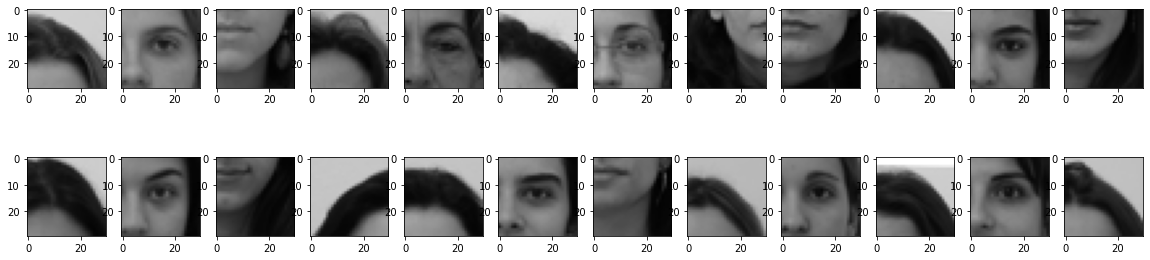

In [21]:
_, axs = plt.subplots(2,int(len(lst_img_1)/2), figsize=(20, 5))
axs = axs.flatten()
for img, ax in zip(lst_img_1, axs):
#     img = cv2.imread(str(img))
    ax.imshow(img)
plt.show()


## KNN

In [38]:
copy_lst = np.copy(lst_1)
copy_lst = np.sort(copy_lst)
sort_list = []
for i in range(len(copy_lst)):
    index = lst_1.index(copy_lst[i])
    sort_list.append(index)

In [40]:
final_patch_1 = []
for i in range(0,5):
    x = lst_img_1[sort_list[i]]
    final_patch_1.append(x)

## subtract mean intesity

In [22]:
def mean_intensity(path_in ,path_out):
    i = 0
    for img in glob.glob(r'C:\Users\fateme\Desktop\{}\*.png'.format(path_in)):
        img = cv2.imread(img)
        img1 = img - np.mean(img)
        i += 1
        cv2.imwrite(r'C:\Users\fateme\Desktop\{path_out}\{index}.png'.format(path_out = path_out, index = i),img1)

In [23]:
mean_intensity('patch_nimg','sub_img')

In [24]:
mean_intensity('candidate_patches','sub_img_cand')

## DCT transform on noisy img and noise free image

In [25]:
#Opens the noisy image.
noise_image_path = r'noisy_image.png'
noise_image = Image.open(noise_image_path)

# Opens the binarize image
ground_truth_image_path = r'C:\Users\fateme\Desktop\face\test\4.png'
ground_truth_image = Image.open( ground_truth_image_path)

#Converts the images into Ndarray
noise_image = np.array(noise_image)
ground_truth_image = np.array(ground_truth_image)

#Create variables `noise_dct_data` and `ground_truth_dct_data` where the DCT coefficients of the two images will be stored.
noise_image_size = noise_image.shape
noise_dct_data = np.zeros(noise_image_size)      
ground_truth_image_size = ground_truth_image.shape
ground_truth_dct_data = np.zeros(ground_truth_image_size)

for i in r_[:noise_image_size[0]:8]:
    for j in r_[:noise_image_size[1]:8]:   
        # Apply DCT to the two images every 8x8 block of it.             
        noise_dct_data[i:(i+8),j:(j+8)] = dct(noise_image[i:(i+8),j:(j+8)])
        # Apply DCT to the binarize image every 8x8 block of it.   
        ground_truth_dct_data[i:(i+8),j:(j+8)] = dct(ground_truth_image[i:(i+8),j:(j+8)])

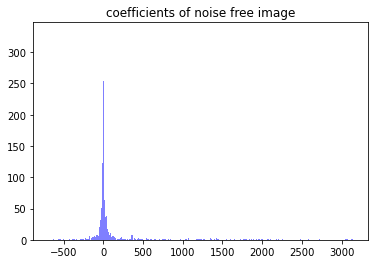

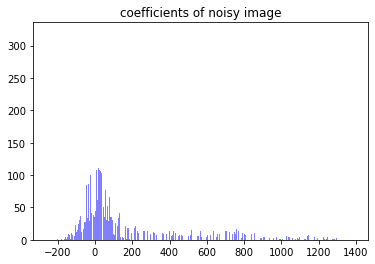

In [43]:
#Convert 2D array to 1D array        
noise_dct_data = noise_dct_data.ravel()   
ground_truth_dct_data = ground_truth_dct_data.ravel()       

#histogram
plt.title('coefficients of noise free image')
n, bins, patches = plt.hist(ground_truth_dct_data, 2000, facecolor='blue', alpha=0.5)
plt.show()

plt.title('coefficients of noisy image')
n, bins, patches = plt.hist(noise_dct_data, 2000, facecolor='blue', alpha=0.5)
plt.show()


## patch transformation

In [ ]:
def patch_transform(patch):
    patch_image = np.array(patch)

    #Create variables `noise_dct_data` and `ground_truth_dct_data` where the DCT coefficients of the two images will be stored.
    patch_image_size = patch_image.shape
    patch_dct_data = np.zeros(noise_image_size)      

    #Apply dct
    patch_dct_data = dct(patch_image)
    return patch_dct_data

In [ ]:
transformed_lst_1 = []
for i in range(len(lst_img_1)):
    z = patch_transform(lst_img_1[i])
    transformed_lst_1.append(z)

In [ ]:
np.mean(transformed_lst_1)